In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

from scikeras.wrappers import KerasClassifier

import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import seaborn as sb

# Comparison of Classifiers for Student Performance Prediction

The objective in this assignment is to compare the performance of different classifiers on the Student Performance dataset Download Student Performance dataset. What is the best algorithm for the dataset? How does ANNs compare to other ML methods? What is the best ANN architecture? 

In [8]:
student_data = pd.read_csv('data/data.csv',sep=';')
student_data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Introduction
This is an extension of Supervised Learning II: Classifier for Breast Cancer. In this project, I will use the same dataset but apply Artificial Neural Networks (ANNs) to evaluate their performance and compare the results to those obtained with previous methods. Since I already conducted exploratory data analysis in the previous assignment, I will reuse the same preprocessing steps and pipelines. To maintain better organization, I will keep this extended assignment in a separate file. 
  
The models I will be comparing are the MLPClassifier and Keras Sequential models with two different architectures.
  
The steps i will follow in this assignment:  
        1. Hyperparameter Tuning: I will be using nested grid search to find the best parameters for each model  
        2. Model evaluation: evaluating using accuracy, precision, recall, the f-measure and roc-auc to conclude which is the best model. 

# preprocessing of data

# encoding categorical value
to make it easier for the functions used later

In [9]:
label_encoder = LabelEncoder()

student_data['Target'] = label_encoder.fit_transform(student_data['Target'])

student_data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2


# PCA (dimention reduction)
usually works best with scaler, that is why i am testing it in combination of standardscaler

In [10]:
pca = ColumnTransformer([
     
     ("pca1", PCA(1), [7, 20]),        # international and nationality
     ("pca2", PCA(1), [10, 11]),       # mother and fathers occupation
     ("pca3", PCA(1), [21, 27]),       # Curricular units 1st sem matching with their corresponding Curricular units 2nd sem
     ("pca4", PCA(1), [22, 28]),
     ("pca5", PCA(1), [23, 29]),
     ("pca6", PCA(1), [24, 30]),
     ("pca7", PCA(1), [25, 31]),
     ("pca8", PCA(1), [26, 32])
     ], remainder='passthrough')      #the rest of the columns get added back, so we dont loose on important information

# pipe with all the changes to the dataset

In [11]:
def pipe_scaled(model):
    return Pipeline([('scaler', StandardScaler()), ('classifier', model)])

In [12]:
def pipe_scaled_pca(model):
    return Pipeline([('scaler', StandardScaler()), ('pca', pca), ('classifier', model)])

In [13]:
def pipe_normalized_pca_balanced(model):
    return imbpipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('pca', pca),
    ('classifier', model)
])

# Split the dataset into suitable partitions

In [14]:
features = student_data.drop('Target', axis=1)
targets = student_data['Target']

train_val_features, test_features, train_val_targets, test_targets = train_test_split(features, targets, test_size=0.2)

# hyperparameter tuning to find the best possible network configuration 
I will test the models in two rounds. In the first round, I will evaluate which dataset provides the best results for the models. In the second round, I will take the best-performing model and dataset combination and fine-tune the parameters to achieve the optimal results.

# Round One: Finding the Best dataset for the models
In this round, I will determine which alterations of the dataset yield the best results. I will test every model with each dataset variation. Once I identify the best-performing dataset, I will use it to fine-tune the models' parameters. This approach reduces runtime by allowing me to focus first on selecting the optimal dataset before delving into parameter optimization. For now, I will test simple models with default parameters. I will first test with default parameters.

# function to evaluate model

In [15]:
def evaluate(estimator, X, y, model_type): 
    if model_type == 'sklearn':
        probabilities = estimator.predict_proba(X)
    elif model_type == 'keras':
        probabilities = estimator.predict(X)
    
    prediction_indices = np.argmax(probabilities, axis=1)
    
    return {
        'accuracy': accuracy_score(y, prediction_indices),
        'precision': precision_score(y, prediction_indices, average='weighted'),
        'recall': recall_score(y, prediction_indices, average='weighted'),
        'f1': f1_score(y, prediction_indices, average='weighted'),
        'roc_auc': roc_auc_score(y, probabilities, multi_class="ovr") 
    }

# MLP classifier
I will first test the MLP classifier. This is a type of neural network that can be used like any other classifier, even though it is based on a neural network architecture. It is a feedforward neural network that uses dense layers.
The MLP classifier is particularly useful for a variety of reasons, it is used to learn non-linear relationships and see more complex patterns.

# MLP classifier with original dataset

In [30]:
mlp_classifier = MLPClassifier(max_iter=1000).fit(train_val_features, train_val_targets)
evaluate(mlp_classifier, test_features, test_targets, 'sklearn')

{'accuracy': 0.6011299435028249,
 'precision': 0.6215220613480804,
 'recall': 0.6011299435028249,
 'f1': 0.5289921996211034,
 'roc_auc': 0.7882502110095643}

# MLP classifier with scaled dataset

In [ ]:
mlp_model = MLPClassifier(max_iter=1000)

mlp_pipe_1 = pipe_scaled(mlp_model)
mlp_pipe_1.fit(train_val_features, train_val_targets)

evaluate(mlp_pipe_1, test_features, test_targets, 'sklearn')

{'accuracy': 0.7062146892655368,
 'precision': 0.7043545581434714,
 'recall': 0.7062146892655368,
 'f1': 0.705116390276474,
 'roc_auc': 0.8286473473586214}

# MLP classifier with scaling and pca

In [ ]:
mlp_model = MLPClassifier(max_iter=1000)

mlp_pipe_2 = pipe_scaled_pca(mlp_model)
mlp_pipe_2.fit(train_val_features, train_val_targets)


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


{'accuracy': 0.6994350282485876,
 'precision': 0.7007787981114373,
 'recall': 0.6994350282485876,
 'f1': 0.7000551202453517,
 'roc_auc': 0.8226262495461727}

# MLP classifier with scaling, oversamling and pca

In [ ]:
mlp_model = MLPClassifier(max_iter=1000)

mlp_pipe_3 = pipe_normalized_pca_balanced(mlp_model)
mlp_pipe_3.fit(train_val_features, train_val_targets)


evaluate(mlp_pipe_3, test_features, test_targets, 'sklearn')

{'accuracy': 0.6903954802259887,
 'precision': 0.6863132480125645,
 'recall': 0.6903954802259887,
 'f1': 0.6881036867120721,
 'roc_auc': 0.8205456228070312}

# Sequential model 1 with simple architecture
For the first sequential model, I am using a simpler architecture with only dense layers. The dense layer is commonly used in neural networks to connect every neuron in one layer to every neuron in the next layer, making it a fully connected layer

# Sequential model 1 with original dataset

In [20]:
sequential_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(36,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

sequential_model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

sequential_model1.fit(train_val_features, train_val_targets, epochs=20, batch_size=4)

evaluate(sequential_model1, test_features, test_targets, 'keras')

Epoch 1/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4420 - loss: 36.2981
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.5247 - loss: 15.8454
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5404 - loss: 14.2328
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5426 - loss: 17.4389
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - accuracy: 0.5760 - loss: 13.1907
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.5992 - loss: 13.0726
Epoch 7/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.6033 - loss: 13.4915
Epoch 8/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - accuracy: 0.6049 - loss: 13.4931
Epoch 9/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.6186 - loss: 12.4464
Epoch 10/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.6007 - loss: 14.9045
Epoch 11/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.6251 - loss: 11.0704
Epoch 12/20
885/885 ━━━━━

{'accuracy': 0.6135593220338983,
 'precision': 0.6713168388787885,
 'recall': 0.6135593220338983,
 'f1': 0.5644298827781788,
 'roc_auc': 0.7992621615953245}

# Sequential model 1 with scaled dataset

In [34]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(36,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model1

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe_1 = pipe_scaled(model)


sequential_model1_pipe_1.fit(train_val_features, train_val_targets)

evaluate(sequential_model1_pipe_1, test_features, test_targets, 'sklearn')

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


{'accuracy': 0.7423728813559322,
 'precision': 0.7336979316319859,
 'recall': 0.7423728813559322,
 'f1': 0.7329983683375254,
 'roc_auc': 0.8579928600929954}

# Sequential model 1 with scaled and pca dataset

In [35]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(28,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model1

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe_2 = pipe_scaled_pca(model)


sequential_model1_pipe_2.fit(train_val_features, train_val_targets)

evaluate(sequential_model1_pipe_2, test_features, test_targets, 'sklearn')

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


{'accuracy': 0.7423728813559322,
 'precision': 0.7280420954682869,
 'recall': 0.7423728813559322,
 'f1': 0.7315065843677642,
 'roc_auc': 0.8578378876372884}

# Sequential model 1 with scaled, balanced and pca dataset

In [36]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(28,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model1

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe_3 = pipe_normalized_pca_balanced(model)


sequential_model1_pipe_3.fit(train_val_features, train_val_targets)

evaluate(sequential_model1_pipe_3, test_features, test_targets, 'sklearn')

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


{'accuracy': 0.696045197740113,
 'precision': 0.708944122373936,
 'recall': 0.696045197740113,
 'f1': 0.7013277771187427,
 'roc_auc': 0.8316241843474934}

# sequential model 2 with dropout and dense layer
For the second sequential model, I am testing a combination of dense layers and a dropout layer. The dense layer is commonly used in neural networks to connect every neuron in one layer to every neuron in the next layer, making it a fully connected layer. The dropout layer, on the other hand, is used to prevent overfitting by randomly setting a fraction of the input units to zero during training, which helps the model generalize better. By using both layers, I aim to create a balanced architecture that can learn effectively while avoiding overfitting

# sequential model 2 with orignal dataset

In [19]:
sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(36,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
])
sequential_model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

sequential_model2.fit(train_val_features, train_val_targets, epochs=20, batch_size=4)

evaluate(sequential_model2, test_features, test_targets, 'keras')

Epoch 1/20


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


885/885 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4271 - loss: 45.2840
Epoch 2/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.4915 - loss: 25.6152
Epoch 3/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5460 - loss: 18.6206
Epoch 4/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step - accuracy: 0.5281 - loss: 24.8344
Epoch 5/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.5732 - loss: 16.7666
Epoch 6/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 851us/step - accuracy: 0.5347 - loss: 21.7838
Epoch 7/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.5523 - loss: 19.0840
Epoch 8/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.5889 - loss: 16.3735
Epoch 9/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.5740 - loss: 15.2463
Epoch 10/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.5689 - loss: 16.9296
Epoch 11/20
885/885 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5784 - loss: 17.1946
Epoch 12/20
885/885 ━━━━━━━━━━━━━━━━

{'accuracy': 0.6033898305084746,
 'precision': 0.7629283344424976,
 'recall': 0.6033898305084746,
 'f1': 0.6388026191791899,
 'roc_auc': 0.8340727364564348}

# sequential model 2 with scaled dataset

In [37]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(36,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model2

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe_1 = pipe_scaled(model)


sequential_model2_pipe_1.fit(train_val_features, train_val_targets)

evaluate(sequential_model2_pipe_1, test_features, test_targets, 'sklearn')


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


{'accuracy': 0.751412429378531,
 'precision': 0.7323867513413586,
 'recall': 0.751412429378531,
 'f1': 0.7342591443118415,
 'roc_auc': 0.8652800511977005}

# sequential model 2 with scaled and pca dataset

In [38]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(28,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model2

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe_2 = pipe_scaled_pca(model)


sequential_model2_pipe_2.fit(train_val_features, train_val_targets)

evaluate(sequential_model2_pipe_2, test_features, test_targets, 'sklearn')


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


{'accuracy': 0.7367231638418079,
 'precision': 0.7158840210134269,
 'recall': 0.7367231638418079,
 'f1': 0.720775704039399,
 'roc_auc': 0.8599880038614324}

# sequential model 2 with scaled, balanced and pca dataset

In [39]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(28,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
    sequential_model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return sequential_model2

model = KerasClassifier(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe_3 = pipe_normalized_pca_balanced(model)


sequential_model2_pipe_3.fit(train_val_features, train_val_targets)

evaluate(sequential_model2_pipe_3, test_features, test_targets, 'sklearn')


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


{'accuracy': 0.711864406779661,
 'precision': 0.7298588325729314,
 'recall': 0.711864406779661,
 'f1': 0.7190072202549824,
 'roc_auc': 0.8479031382009525}

# all results from round one:

In [46]:
print("MLP classifier")
print("Original dataset:")
print(evaluate(mlp_classifier, test_features, test_targets, 'sklearn'))
print("scaled dataset:")
print(evaluate(mlp_pipe_1, test_features, test_targets, 'sklearn'))
print("scaled and pca dataset:")
print(evaluate(mlp_pipe_2, test_features, test_targets, 'sklearn'))
print("scaled, balanced and pca dataset:")
print(evaluate(mlp_pipe_3, test_features, test_targets, 'sklearn'))
print()
print("Sequential model architecture 1")
print("Original dataset:")
print(evaluate(sequential_model1, test_features, test_targets, 'keras'))
print("scaled dataset:")
print(evaluate(sequential_model1_pipe_1, test_features, test_targets, 'sklearn'))
print("scaled and pca dataset:")
print(evaluate(sequential_model1_pipe_2, test_features, test_targets, 'sklearn'))
print("scaled, balanced and pca dataset:")
print(evaluate(sequential_model1_pipe_3, test_features, test_targets, 'sklearn'))
print()
print("Sequential model architecture 2")
print("Original dataset:")
print(evaluate(sequential_model2, test_features, test_targets, 'keras'))
print("scaled dataset:")
print(evaluate(sequential_model2_pipe_1, test_features, test_targets, 'sklearn'))
print("scaled and pca dataset:")
print(evaluate(sequential_model2_pipe_2, test_features, test_targets, 'sklearn'))
print("scaled, balanced and pca dataset:")
print(evaluate(sequential_model2_pipe_3, test_features, test_targets, 'sklearn'))

MLP classifier
Original dataset:
{'accuracy': 0.6011299435028249, 'precision': 0.6215220613480804, 'recall': 0.6011299435028249, 'f1': 0.5289921996211034, 'roc_auc': 0.7882502110095643}
scaled dataset:
{'accuracy': 0.7062146892655368, 'precision': 0.7043545581434714, 'recall': 0.7062146892655368, 'f1': 0.705116390276474, 'roc_auc': 0.8286473473586214}
scaled and pca dataset:
{'accuracy': 0.7084745762711865, 'precision': 0.7025188754248678, 'recall': 0.7084745762711865, 'f1': 0.7039989041324511, 'roc_auc': 0.8252877665837791}
scaled, balanced and pca dataset:
{'accuracy': 0.6892655367231638, 'precision': 0.6863177415202129, 'recall': 0.6892655367231638, 'f1': 0.6876235619884556, 'roc_auc': 0.8211662670688852}

Sequential model architecture 1
Original dataset:
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
{'accuracy': 0.6135593220338983, 'precision': 0.6713168388787885, 'recall': 0.6135593220338983, 'f1': 0.5644298827781788, 'roc_auc': 0.7992621615953245}
scaled dataset:
{'accuracy': 0.7423728

It looks like all models achieved the best results with the scaled dataset. The scaled and PCA dataset produced very similar results, indicating that PCA did not have a significant positive effect on performance. Therefore, we can conclude that PCA is not really necessary for improving the results in this case. Oversampling the dataset was also not necessary, as it resulted in worse overall performance.

# Round two of finding the best models

# grid search funtion
I am using a normal grid search function, this will help me find the best models by finding the best parameter combinations. i wanted to use neted grid search which is even better to find the best parameters, but too high runtime.

In [52]:
def find_best_models(model, dt_params):
    precision_scorer = make_scorer(precision_score, average='weighted', zero_division=0)

    metrics = {
        'accuracy': 'accuracy',
        'precision_weighted': precision_scorer,
        'recall_weighted': 'recall_weighted',
        'f1_weighted': 'f1_weighted',
        'roc_auc_ovr_weighted': 'roc_auc_ovr_weighted'
    }

    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

    dt_cv_results = []
    dt_estimators = []
    dt_test_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
    }

    dt_grid = GridSearchCV(model, dt_params, cv=inner_cv, scoring=metrics, refit='f1_weighted',return_train_score=True)
    dt_grid.fit(train_val_features, train_val_targets)

    cv_results = pd.DataFrame(dt_grid.cv_results_)
    dt_cv_results.append(cv_results)
    dt_estimators.append(dt_grid.best_estimator_)

    evaluation = evaluate(dt_grid, train_val_features, train_val_targets, 'sklearn')
    dt_test_scores['accuracy'].append(evaluation['accuracy'])
    dt_test_scores['precision'].append(evaluation['precision'])
    dt_test_scores['recall'].append(evaluation['recall'])
    dt_test_scores['f1'].append(evaluation['f1'])
    dt_test_scores['roc_auc'].append(evaluation['roc_auc'])
    return dt_estimators, dt_cv_results, dt_test_scores



# MLPClassifier

parameters i will tune:  
hidden_layer_sizes: Defines the number of hidden layers and neurons, affecting the model's complexity and learning capacity.
  
activation: Specifies the activation function for hidden layers, introducing non-linearity to improve learning (e.g., 'relu', 'tanh', 'logistic').
  
solver: Determines the optimization method used to minimize the loss function (e.g., 'sgd', 'adam').
  
max_iter: Sets the maximum number of iterations. If the model doesn't converge, early stopping is enabled to prevent unnecessary training


In [75]:
MLP_params = {
        'classifier__hidden_layer_sizes': [(80,), (100,), (120,), (140)],
        'classifier__activation': ['logistic', 'tanh', 'relu'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__max_iter': [150, 200, 250],
        'classifier__alpha': [1e-4, 1e-3, 1e-2, 1e-1]
        
    }
best_models_mlp_model, cv_results_MLP, model_scores_MLP = find_best_models(pipe_scaled(MLPClassifier(early_stopping=True)), MLP_params)

# Plotting the parameters in a graph

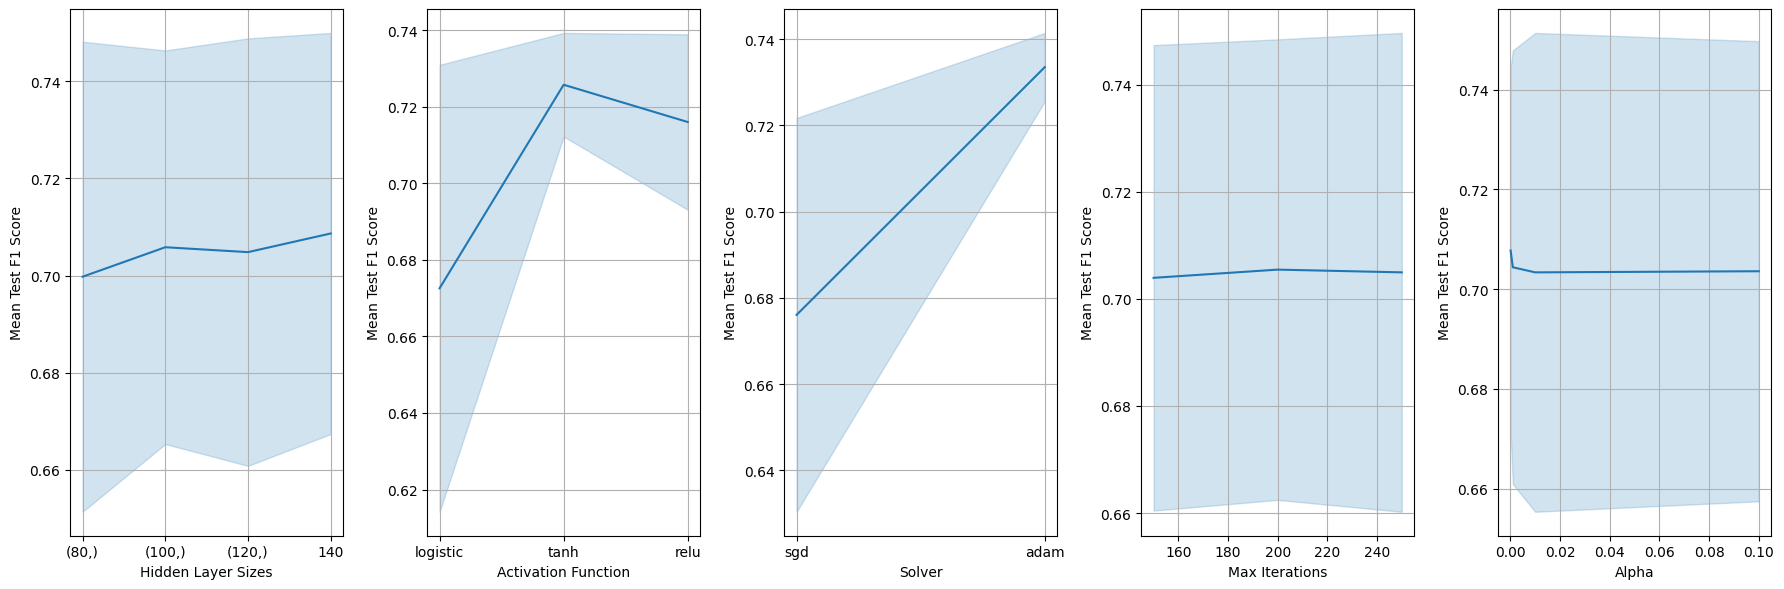

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 5, 1)
sb.lineplot(data=cv_results_MLP, x='param_classifier__hidden_layer_sizes', y='mean_test_f1_weighted', estimator='mean', errorbar='sd')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Mean Test F1 Score')
plt.grid()

plt.subplot(1, 5, 2)
sb.lineplot(data=cv_results_MLP, x='param_classifier__activation', y='mean_test_f1_weighted', estimator='mean', errorbar='sd')
plt.xlabel('Activation Function')
plt.ylabel('Mean Test F1 Score')
plt.grid()


plt.subplot(1, 5, 3)
sb.lineplot(data=cv_results_MLP, x='param_classifier__solver', y='mean_test_f1_weighted', estimator='mean', errorbar='sd'
)
plt.xlabel('Solver')
plt.ylabel('Mean Test F1 Score')
plt.grid()

plt.subplot(1, 5, 4)
sb.lineplot(data=cv_results_MLP, x='param_classifier__max_iter', y='mean_test_f1_weighted', estimator='mean', errorbar='sd')
plt.xlabel('Max Iterations')
plt.ylabel('Mean Test F1 Score')
plt.grid()

plt.subplot(1, 5, 5)
sb.lineplot(data=cv_results_MLP, x='param_classifier__alpha', y='mean_test_f1_weighted', estimator='mean', errorbar='sd')
plt.xlabel('Alpha')
plt.ylabel('Mean Test F1 Score')
plt.grid()

plt.tight_layout()
plt.show()

# the best model from the grid search

In [85]:
print(best_models_mlp_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 MLPClassifier(alpha=0.001, early_stopping=True,
                               hidden_layer_sizes=140))])]


In [86]:
best_model_mlp = best_models_mlp_model[0]
evaluate(best_model_mlp, test_features, test_targets, 'sklearn')

{'accuracy': 0.7581920903954802,
 'precision': 0.7395378804204252,
 'recall': 0.7581920903954802,
 'f1': 0.7431283121825174,
 'roc_auc': 0.8743212274818531}

# sequential models:
The parameters i am tuning:  
optimizer: Determines how the model updates its weights during training (e.g., 'adam', 'sgd').
  
epochs: The number of complete passes through the dataset during training.
  
batch size: The number of training samples processed before updating the model's weights.
  
number of hidden layers: Controls the depth of the network, influencing the model's complexity.
  
number of neurons in the layers: Defines the size of each layer, impacting how many details the model can capture.

# sequential model #1
to use grid search on a model that is not an sklearn classifier i have to wrap it in with a kerasregressor, so i can use sklearn functions with it, like pipe also. I also made a custom hidden_layers parameter so i can tune number of layers and see what works best for my model

In [ ]:
def create_model(hidden_layers=1, optimizer='adam', activation='relu', num_neurons=128):
    model = Sequential({tf.keras.layers.Input(shape=(28,))})

    for _ in range(hidden_layers - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(3, activation='softmax')) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


param_grid = {
    'classifier__model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'classifier__epochs': [10, 20, 50],
    'classifier__batch_size': [16, 32, 64,],
    'classifier__hidden_layers': [10, 20, 30],
    'classifier__num_neurons': [32, 64, 128]
}



model = KerasClassifier(model=create_model, hidden_layers=1, num_neurons=128 ,verbose=0)

pipeline = pipe_scaled_pca(model)
best_models_S_model, cv_results_sq1, model_scores = find_best_models(pipeline, param_grid)



In [90]:
print(best_models_S_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=1),
                                                  [7, 20]),
                                                 ('pca2', PCA(n_components=1),
                                                  [10, 11]),
                                                 ('pca3', PCA(n_components=1),
                                                  [21, 27]),
                                                 ('pca4', PCA(n_components=1),
                                                  [22, 28]),
                                                 ('pca5', PCA(n_components=1),
                                                  [23, 29]),
                                                 ('pca6', PCA(n_components=1),
                                                  [24, 30]),
                              

# the best model

In [91]:
best_model_S1 = best_models_S_model[0]
evaluate(best_model_S1, test_features, test_targets, 'sklearn')

{'accuracy': 0.7163841807909604,
 'precision': 0.7067152132170276,
 'recall': 0.7163841807909604,
 'f1': 0.7110351663668457,
 'roc_auc': 0.8397835076959083}

# sequential model #2
Additionally, I am tuning the following parameters:  
drop_out: The percentage of neurons to be dropped during training to prevent overfitting.  
hidden_layers_drop_out: The number of hidden layers to retain after each dense layer, which affects the depth of the model.

In [95]:
def create_model(drop_out=0.1, hidden_layers=1, hidden_layers_drop_out=1, optimizer='adam', activation='relu', num_neurons=128):
    model = Sequential({tf.keras.layers.Input(shape=(28,))})

    for _ in range(hidden_layers - 1):
        model.add(Dense(num_neurons, activation=activation))
        if hidden_layers_drop_out > 0:
            model.add(Dropout(drop_out))

    model.add(Dense(3, activation='softmax')) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


param_grid = {
    'classifier__model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'classifier__epochs': [10, 20, 50],
    'classifier__batch_size': [32, 64],
    'classifier__hidden_layers': [2, 3],
    'classifier__num_neurons': [64, 128],
    'classifier__drop_out': [0.1, 0.3],
    'classifier__hidden_layers_drop_out': [2, 3],
}



model = KerasClassifier(model=create_model, drop_out=0.1, hidden_layers=1, hidden_layers_drop_out=1, num_neurons=128 ,verbose=0)

pipeline = pipe_scaled_pca(model)
best_models_S_model, cv_results_sq2, model_scores = find_best_models(pipeline, param_grid)



c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [96]:
print(best_models_S_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca1', PCA(n_components=1),
                                                  [7, 20]),
                                                 ('pca2', PCA(n_components=1),
                                                  [10, 11]),
                                                 ('pca3', PCA(n_components=1),
                                                  [21, 27]),
                                                 ('pca4', PCA(n_components=1),
                                                  [22, 28]),
                                                 ('pca5', PCA(n_components=1),
                                                  [23, 29]),
                                                 ('pca6', PCA(n_components=1),
                                                  [24, 30]),
                              

In [97]:
best_model_S2 = best_models_S_model[0]
evaluate(best_model_S2, test_features, test_targets, 'sklearn')

{'accuracy': 0.7593220338983051,
 'precision': 0.7405232886890536,
 'recall': 0.7593220338983051,
 'f1': 0.7432842480423395,
 'roc_auc': 0.8705413811959183}

# comparing the results of the best models found

In [98]:
print("best MLP model")
print(evaluate(best_model_mlp, test_features, test_targets, 'sklearn'))
print()
print("best sequential model with the first architecture")
print(evaluate(best_model_S1, test_features, test_targets, 'sklearn'))
print()
print("best sequential model with the second arthitecture")
print(evaluate(best_model_S2, test_features, test_targets, 'sklearn'))

best MLP model
{'accuracy': 0.7581920903954802, 'precision': 0.7395378804204252, 'recall': 0.7581920903954802, 'f1': 0.7431283121825174, 'roc_auc': 0.8743212274818531}

best sequential model with the first architecture
{'accuracy': 0.7163841807909604, 'precision': 0.7067152132170276, 'recall': 0.7163841807909604, 'f1': 0.7110351663668457, 'roc_auc': 0.8397835076959083}

best sequential model with the second arthitecture
{'accuracy': 0.7593220338983051, 'precision': 0.7405232886890536, 'recall': 0.7593220338983051, 'f1': 0.7432842480423395, 'roc_auc': 0.8705413811959183}


# visuall representation of the results with confusion matrix
0: Dropout
1: enrolled
2:Graduate

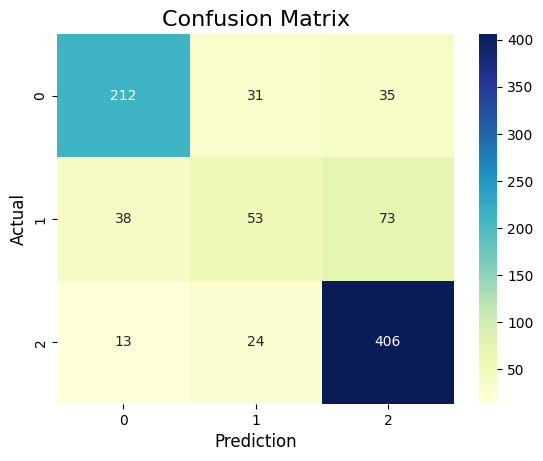

In [101]:
y_pred = best_model_mlp.predict(test_features)
cm = confusion_matrix(test_targets, y_pred)

sb.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

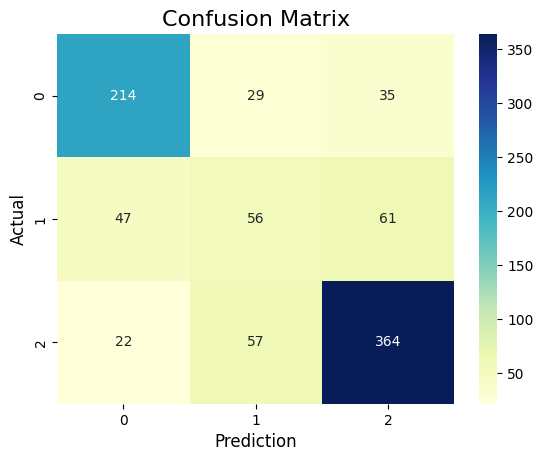

In [99]:
y_pred = best_model_S1.predict(test_features)
cm = confusion_matrix(test_targets, y_pred)

sb.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

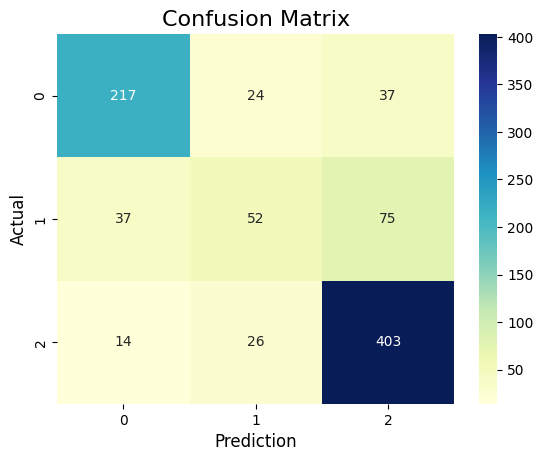

In [100]:
y_pred = best_model_S2.predict(test_features)
cm = confusion_matrix(test_targets, y_pred)

sb.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Conclusion
The results from the first round:  
The scaled data generally produced the best results. Scaling is often beneficial when working with Artificial Neural Networks, as it helps the model converge more efficiently and improves overall performance. There was a noticeable improvement compared to the original dataset. However, the scaled data combined with PCA resulted in slightly lower performance, indicating that PCA was not particularly effective for this dataset when used with ANN. This could be because oversampling may have altered the features too significantly, potentially introducing noise or synthetic patterns that did not align well with the original data distribution.
  
The results of the second round:   
The sequential model with the second architecture achieved the best results, with the MLP model coming in as a very close second. All three models demonstrated strong performance, suggesting that they are capable of accurately predicting the categories and distinguishing between the groups in most cases. However, the differences between the top models were minimal, indicating that both the second sequential model and the MLP model are viable options for this task
  
Confusion matrix results:  
The confusion matrix shows that most of the models correctly classified the categories. The sequential model with the second architecture had the highest number of correct predictions. It struggled slightly with distinguishing between "graduated" and "enrolled," but this is not the most critical issue, as the key objective is identifying whether someone is dropping out. The MLP model had slightly fewer correct predictions, with the same challenge in distinguishing between "graduated" and "enrolled." The sequential model with the first architecture had a few more incorrect predictions and had even more difficulty differentiating between "graduated" and "enrolled." However, most of the models performed well in distinguishing between "dropout" and "non-dropout," which is the most important aspect for this task. Overall, the best performing model was the sequential model with architecture 2, though the MLP model was close behind.

  
The best model:  
The MLP model can be considered the best overall. While its performance was very close to that of the second sequential model, which had slightly better results, the MLP model stands out due to its simplicity and efficiency. Being an sklearn model, it is much easier to set up and tune its parameters compared to the sequential model. Additionally, it requires significantly less time to train, making it more practical for broader use

Things to consider with these results:
  
I could have explored more parameters, but the process was very time-consuming, so I may not have found the absolute best models for each type. The Keras models, in particular, had extremely high runtimes, even when using a regular grid search instead of a nested one. I would have liked to experiment with different architectures, such as varying the number of layers and testing more hyperparameters, but I was constrained by time. Alternatively, I could have used RandomizedSearchCV, which is faster, but it does not guarantee finding the best model since it only samples a subset of the parameter space.
  
  
Compare results to regular sklearn models from supervised learning II:
When comparing the results to the regular sklearn models from Supervised Learning II, the Random Forest model with the altered data (scaled, balanced, and PCA) performed a bit better. Random Forests tend to work well for classification problems like this one, especially when the data has a mix of features and complex relationships. On the other hand, ANNs are better suited for more complex problems like image recognition, where the relationships between features are more intricate. In this case, the Random Forest model’s simpler structure made it a better fit for this dataset, so I’d go with that over the ANN



# Sources
Scikit-learn Documentation. (n.d.). MLPClassifier. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  
Raza, A. (2020, March 16). Hyperparameter tuning with Keras and GridSearchCV: A comprehensive guide. Medium. Retrieved from https://medium.com/swlh/hyperparameter-tuning-with-keras-and-gridsearchcv-a-comprehensive-guide-46214cc0d999
  
Stack Overflow. (2018, March 25). Grid search the number of hidden layers with Keras. Stack Overflow. Retrieved from https://stackoverflow.com/questions/47788799/grid-search-the-number-of-hidden-layers-with-keras
  
DataCamp. (n.d.). Multilayer perceptrons in machine learning. DataCamp. Retrieved from https://www.datacamp.com/tutorial/multilayer-perceptrons-in-machine-learning?dc_referrer=https%3A%2F%2Fwww.google.com%2F
  
Panjeh, H. (2020, June 9). Scikit-learn hyperparameter optimization for MLPClassifier. Medium. Retrieved from https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b
  
Scikit-learn Documentation: StandardScaler
Scikit-learn. (2024). StandardScaler. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html
  
Medium Article: Introduction to Machine Learning Pipelines
Jang, C. (2020, November 17). Introduction to machine learning pipelines. Medium. Retrieved from https://medium.com/@cezinejang/introduction-to-machine-learning-pipelines-adb041120856
  
StackOverflow: Precision Calculation Warning
StackOverflow. (2020, May 13). Precision calculation warning when using GridSearchCV for logistic regression. Retrieved from https://stackoverflow.com/questions/66538197/precision-calculation-warning-when-using-gridsearchcv-for-logistic-regression
  
Scikit-learn. (2024). GridSearchCV. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html